<a href="https://colab.research.google.com/github/devdandekar24/nifty-price-predictor-lstm-/blob/main/NiftyPricePredictor_usingLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### LSTM

In [1]:
!pip install yfinance

In [7]:
import yfinance as yf

In [8]:
import pandas as pd
import numpy as np


In [9]:
# downloading dataset
nifty = yf.download("^NSEI", start="2015-01-01", end="2024-12-31")
nifty.to_csv("nifty50_data.csv")
print("NIFTY50 Sample:")
nifty.head()

/tmp/ipython-input-9-3319277772.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty = yf.download("^NSEI", start="2015-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed

NIFTY50 Sample:


Price,Close,High,Low,Open,Volume
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
Date,,,,,
2015-01-02,8395.450195,8410.599609,8288.700195,8288.700195,101900
2015-01-05,8378.400391,8445.599609,8363.900391,8407.950195,118200
2015-01-06,8127.350098,8327.849609,8111.350098,8325.299805,172800
2015-01-07,8102.100098,8151.200195,8065.450195,8118.649902,164100
2015-01-08,8234.599609,8243.500000,8167.299805,8191.399902,143800


We will be using closing price because : Close represents the final price after all market activity.



In [10]:
# nifty_df=nifty.reset_index()['Close']

# Feature Engineering
nifty['MA10']          = nifty['Close'].rolling(window=10).mean()
nifty['MA20']          = nifty['Close'].rolling(window=20).mean()
nifty['Return']        = nifty['Close'].pct_change()
nifty['Close_lag_1']   = nifty['Close'].shift(1)
nifty['Close_lag_5']   = nifty['Close'].shift(5)
nifty['Volatility_10'] = nifty['Return'].rolling(window=10).std()


In [11]:
# Target: Tomorrow's Close
nifty['Target'] = nifty['Close'].shift(-1)

In [12]:
nifty.dropna(inplace=True)


In [13]:
nifty.shape

(2438, 12)

In [14]:
# nifty_df.shape

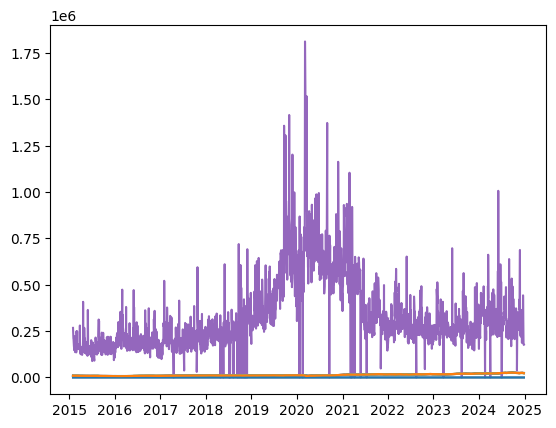

In [15]:
import matplotlib.pyplot as plt
# plt.plot(nifty_df)
plt.plot(nifty)

In [16]:
# normalizing
import joblib
from sklearn.preprocessing import MinMaxScaler

features = [
    'Open', 'High', 'Low', 'Volume',
    'MA10', 'MA20', 'Return',
    'Close_lag_1', 'Close_lag_5', 'Volatility_10'
]

X = nifty[features]
y = nifty['Target']

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ✅ After: scale y as well
target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

In [17]:
y_dates = nifty.index  # these correspond to y

In [18]:
# saving scaler
joblib.dump(scaler, "feature_scaler.pkl")
joblib.dump(target_scaler, "target_scaler.pkl")

['target_scaler.pkl']

In [19]:
def create_sequences(X, y, time_step=60):
    Xs, ys = [], []
    for i in range(time_step, len(X)):
        Xs.append(X[i-time_step:i])
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)

# Sequence window
time_step = 200
X_seq, y_seq = create_sequences(X_scaled, pd.Series(y_scaled), time_step)


In [52]:
# def create_sequences(X, y, dates, time_step=60):
#     Xs, ys, ds = [], [], []
#     for i in range(time_step, len(X)):
#         Xs.append(X[i-time_step:i])
#         ys.append(y[i])
#         ds.append(dates[i])
#     return np.array(Xs), np.array(ys), np.array(ds)

# X_seq, y_seq, date_seq = create_sequences(X_scaled, y_scaled, y_dates, time_step=200)


In [20]:
train_size = int(len(X_seq) * 0.7)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]
# date_test = date_seq[train_size:]


In [44]:
# LSTM model 1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),verbose=1)

model.save("lstm_model.keras")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 204ms/step - loss: 0.0136 - val_loss: 0.0035
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 240ms/step - loss: 3.3945e-04 - val_loss: 0.0014
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 211ms/step - loss: 3.5749e-04 - val_loss: 0.0016
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - loss: 3.1602e-04 - val_loss: 9.3603e-04
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - loss: 2.7400e-04 - val_loss: 0.0014
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - loss: 2.5068e-04 - val_loss: 0.0015
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 209ms/step - loss: 2.4263e-04 - val_loss: 7.3247e-04
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step - loss: 2.4993e-04 - val_loss: 0.0012
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 191ms/step - loss: 2.0872e-04 - val_loss: 0.0011
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - loss: 1.9968e-04 - val_loss: 0.0013
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - loss: 1.9666e-04 - val_loss: 5

In [45]:
# bidirectional model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

model_bidir = Sequential()
model_bidir.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model_bidir.add(Bidirectional(LSTM(64)))
model_bidir.add(Dense(1))

model_bidir.compile(optimizer='adam', loss='mean_squared_error')
model_bidir.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

model.save("bidir_lstm_model.keras")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 412ms/step - loss: 0.0135 - val_loss: 0.0019
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 426ms/step - loss: 4.2984e-04 - val_loss: 0.0027
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 39s 392ms/step - loss: 2.6228e-04 - val_loss: 0.0022
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 391ms/step - loss: 2.5008e-04 - val_loss: 0.0025
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 385ms/step - loss: 2.1608e-04 - val_loss: 0.0024
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 408ms/step - loss: 2.1262e-04 - val_loss: 0.0020
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 385ms/step - loss: 1.8360e-04 - val_loss: 6.4222e-04
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 386ms/step - loss: 1.8501e-04 - val_loss: 0.0012
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 403ms/step - loss: 1.6613e-04 - val_loss: 4.0673e-04
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 384ms/step - loss: 1.5507e-04 - val_loss: 0.0024
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 400ms/step - loss: 2.3460e-04 - val_loss: 3

In [21]:
# lstm model accuracy
from sklearn.metrics import mean_squared_error, r2_score
import math
from tensorflow.keras.models import load_model


model = load_model("lstm_model.keras")
y_pred = model.predict(X_test)
# y_pred = model_bidir.predict(X_test)

# Inverse transform predictions & actual y values
y_pred_actual = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate on actual prices
rmse = math.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)

print("LSTM RMSE (actual ₹):", rmse)
print("LSTM R² Score:", r2)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
LSTM RMSE (actual ₹): 427.60559635001636
LSTM R² Score: 0.9778319047410736


In [55]:
# bidir model accuracy
from sklearn.metrics import mean_squared_error, r2_score
import math

# y_pred = model.predict(X_test)
y_pred = model_bidir.predict(X_test)

# Inverse transform predictions & actual y values
y_pred_actual = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate on actual prices
rmse = math.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)

print("LSTM RMSE (actual ₹):", rmse)
print("LSTM R² Score:", r2)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step
LSTM RMSE (actual ₹): 393.8313653044522
LSTM R² Score: 0.9811954813891528


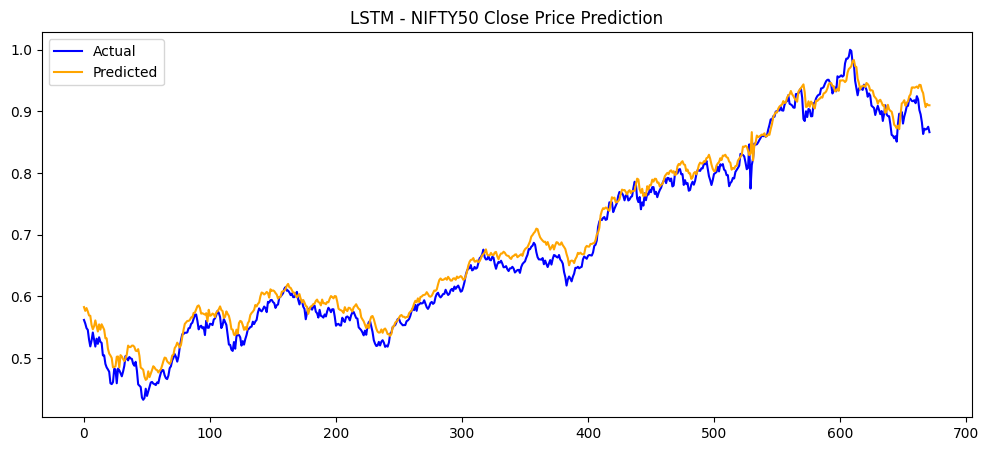

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test, label="Actual", color="blue")
plt.plot(y_pred, label="Predicted", color="orange")
plt.title("LSTM - NIFTY50 Close Price Prediction")
plt.legend()
plt.show()


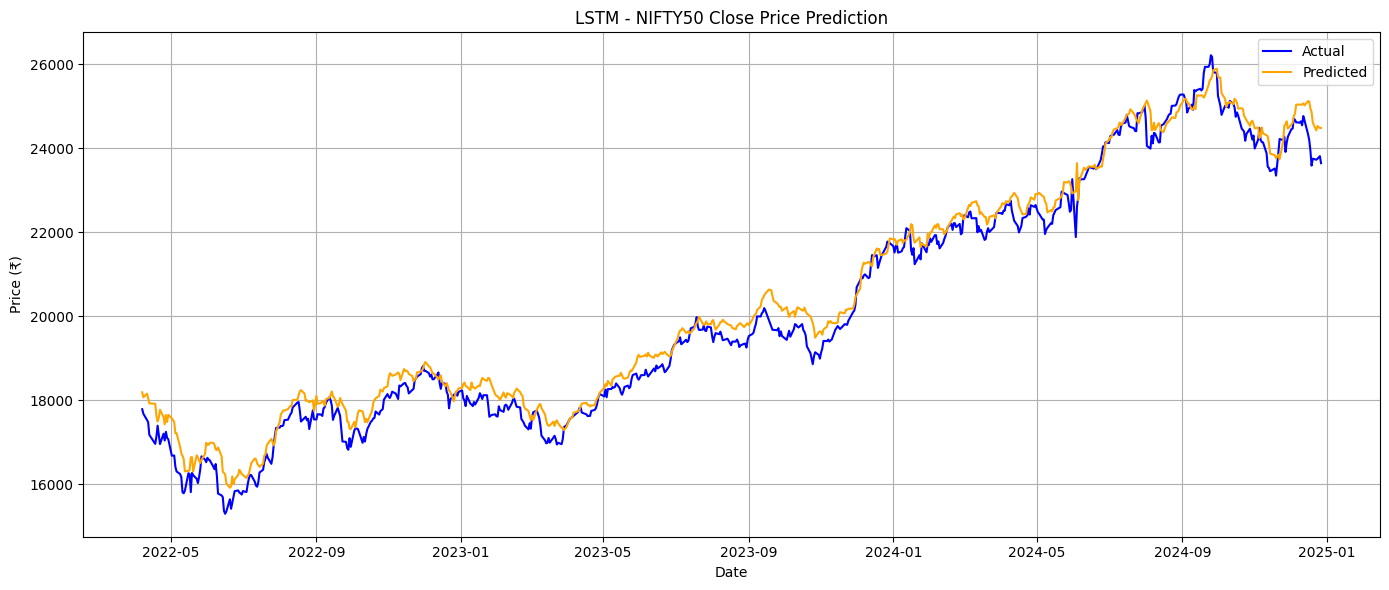

In [56]:
# with dates

plt.figure(figsize=(14, 6))
plt.plot(date_test, y_test_actual, label="Actual", color="blue")
plt.plot(date_test, y_pred_actual, label="Predicted", color="orange")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.title("LSTM - NIFTY50 Close Price Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

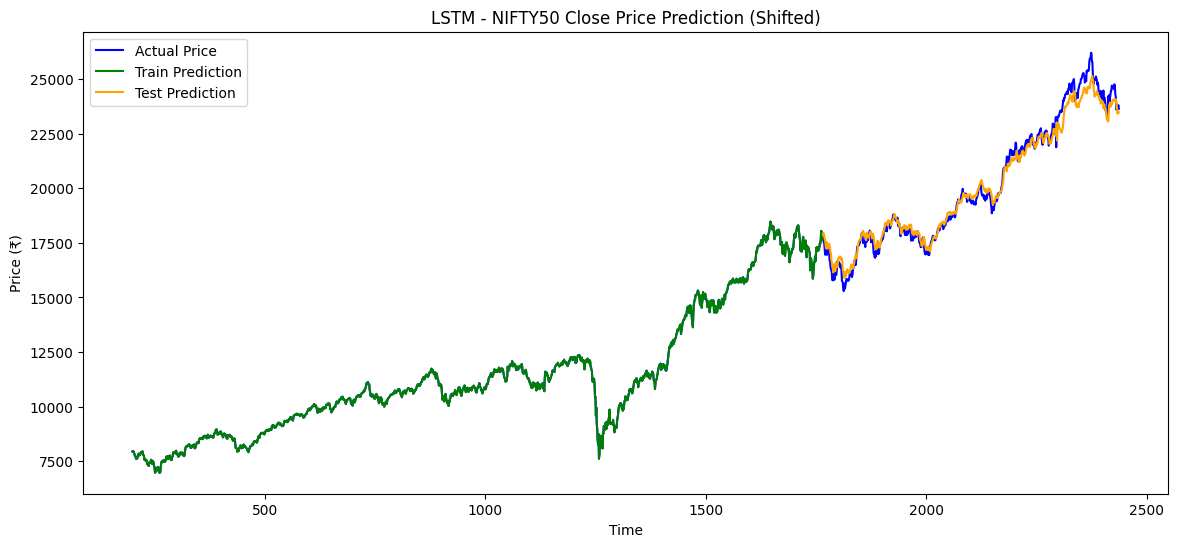

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Reconstruct full dataset from scaler
df1 = scaler.inverse_transform(X_scaled)  # original input features, scaled
df1_close = df1[:, features.index('Close_lag_1')]  # or any close-like column

# Step 2: Shift train predictions for plotting
trainPredictPlot = np.empty((len(df1_close),))
trainPredictPlot[:] = np.nan
trainPredictPlot[time_step:len(y_train)+time_step] = target_scaler.inverse_transform(y_train.reshape(-1,1)).flatten()

# Step 3: Shift test predictions for plotting
testPredictPlot = np.empty((len(df1_close),))
testPredictPlot[:] = np.nan
test_start = len(y_train) + (time_step)
testPredictPlot[test_start:test_start + len(y_pred)] = target_scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()

# Step 4: Actual values
actual_plot = np.empty((len(df1_close),))
actual_plot[:] = np.nan
full_y = np.concatenate((y_train, y_test))
actual_plot[time_step:time_step + len(full_y)] = target_scaler.inverse_transform(full_y.reshape(-1,1)).flatten()

# Step 5: Plotting
plt.figure(figsize=(14,6))
plt.plot(actual_plot, label='Actual Price', color='blue')
plt.plot(trainPredictPlot, label='Train Prediction', color='green')
plt.plot(testPredictPlot, label='Test Prediction', color='orange')
plt.title("LSTM - NIFTY50 Close Price Prediction (Shifted)")
plt.xlabel("Time")
plt.ylabel("Price (₹)")
plt.legend()
plt.show()


according to graph i can see that the bidirectional model is fitting better than simple LSTM model

2. Use walk forward validation
3. Hyperparameter tuning ( not done )
4. Bidirectional LSTM (done)
6. Standardization insted of min max scaler (not done )


Note: LSTM are sensitives to the scale of the data, so we apply MinMax scaler

## trying our models for 2025 data


In [71]:
# 📅 Fetch Future Data
future_data = yf.download("^NSEI", start="2024-07-01", end="2025-06-30")

/tmp/ipython-input-71-2937195843.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  future_data = yf.download("^NSEI", start="2024-07-01", end="2025-06-30")
[*********************100%***********************]  1 of 1 completed


In [72]:
# Feature Engineering
future_data['MA10']          = future_data['Close'].rolling(window=10).mean()
future_data['MA20']          = future_data['Close'].rolling(window=20).mean()
future_data['Return']        = future_data['Close'].pct_change()
future_data['Close_lag_1']   = future_data['Close'].shift(1)
future_data['Close_lag_5']   = future_data['Close'].shift(5)
future_data['Volatility_10'] = future_data['Return'].rolling(window=10).std()

# future_data.dropna(inplace=True)

In [73]:
features = [
    'Open', 'High', 'Low', 'Volume',
    'MA10', 'MA20', 'Return',
    'Close_lag_1', 'Close_lag_5', 'Volatility_10'
]

X_future_scaled = scaler.transform(future_data[features])

In [74]:
time_step = 200
X_seq = []

# use first 60 rows of `X_future_scaled` as base
for i in range(time_step, len(X_future_scaled)):
    X_seq.append(X_future_scaled[i - time_step:i])

X_seq = np.array(X_seq)

In [75]:
print("X_seq shape:", X_seq.shape)


X_seq shape: (47, 200, 10)


In [80]:
# 📈 Predict
predictions_scaled = model_bidir.predict(X_seq, verbose=0)
predictions_actual = target_scaler.inverse_transform(predictions_scaled)

In [81]:
# Match future_data size to predicted output (skip first 60)
plot_df = future_data.iloc[time_step:].copy()
plot_df['Predicted_Close'] = predictions_actual.flatten()

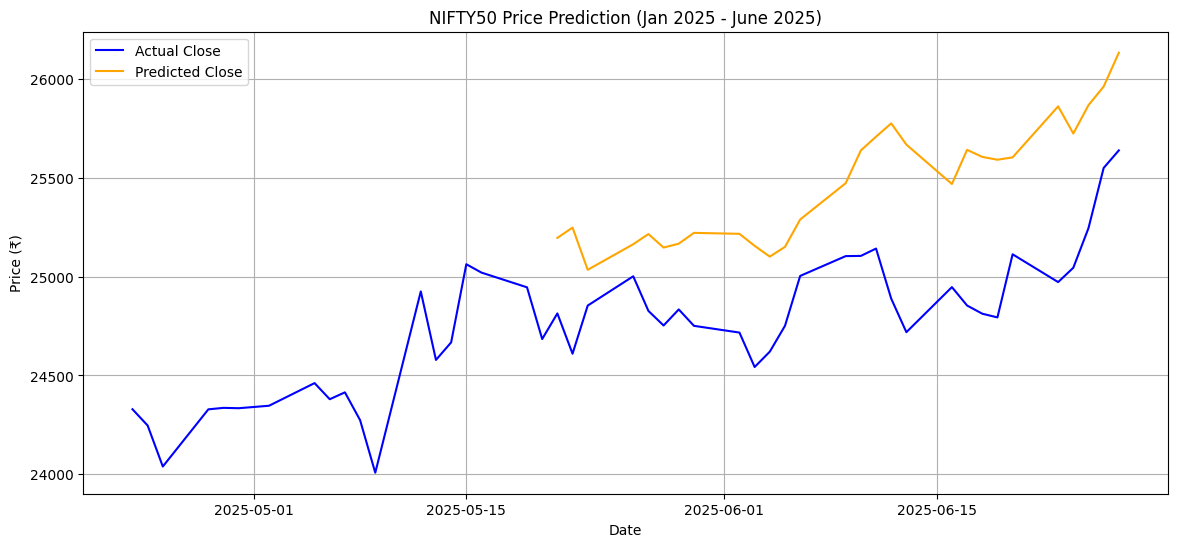

In [82]:
# 📊 Plotting
plt.figure(figsize=(14,6))
plt.plot(plot_df.index, plot_df['Close'], label="Actual Close", color="blue")
plt.plot(plot_df.index, plot_df['Predicted_Close'], label="Predicted Close", color="orange")
plt.title("NIFTY50 Price Prediction (Jan 2025 - June 2025)")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.legend()
plt.grid(True)
plt.show()